# Weight Decay
:label:`sec_weight_decay`

Now that we have characterized the problem of overfitting,
we can introduce our first *regularization* technique.
Recall that we can always mitigate overfitting
by collecting more training data.
However, that can be costly, time consuming,
or entirely out of our control,
making it impossible in the short run.
For now, we can assume that we already have
as much high-quality data as our resources permit
and focus the tools at our disposal
when the dataset is taken as a given.

Recall that in our polynomial regression example
(:numref:`subsec_polynomial-curve-fitting`)
we could limit our model's capacity
by tweaking the degree
of the fitted polynomial.
Indeed, limiting the number of features
is a popular technique for mitigating overfitting.
However, simply tossing aside features
can be too blunt an instrument.
Sticking with the polynomial regression
example, consider what might happen
with high-dimensional input.
The natural extensions of polynomials
to multivariate data are called *monomials*,
which are simply products of powers of variables.
The degree of a monomial is the sum of the powers.
For example, $x_1^2 x_2$, and $x_3 x_5^2$
are both monomials of degree 3.

Note that the number of terms with degree $d$
blows up rapidly as $d$ grows larger.
Given $k$ variables, the number of monomials
of degree $d$ is ${k - 1 + d} \choose {k - 1}$.
Even small changes in degree, say from $2$ to $3$,
dramatically increase the complexity of our model.
Thus we often need a more fine-grained tool
for adjusting function complexity.


# 权重衰减
:label:`sec_weight_decay`

现在我们已经描述了过拟合问题，我们可以引入我们的第一种*正则化*技术。回想一下，我们总是可以通过收集更多的训练数据来减轻过拟合。然而，这可能代价高昂、耗时，或者完全超出我们的控制范围，使其在短期内无法实现。目前，我们可以假设我们已经拥有了资源所允许的尽可能多的高质量数据，并将重点放在当数据集已给定时我们可以使用的工具上。

回想一下在我们的多项式回归示例（:numref:`subsec_polynomial-curve-fitting`）中，我们可以通过调整拟合多项式的阶数来限制模型的容量。确实，限制特征数量是减轻过拟合的流行技术。然而，简单地抛弃特征可能是一种太过粗暴的手段。继续使用多项式回归示例，考虑高维输入可能发生的情况。多项式对多变量数据的自然扩展被称为*单项式*，它们只是变量幂的乘积。单项式的阶数是幂的总和。例如，$x_1^2 x_2$和$x_3 x_5^2$都是3阶单项式。

注意，随着阶数$d$的增大，阶数为$d$的项数迅速增加。给定$k$个变量，阶数为$d$的单项式数量是${k - 1 + d} \choose {k - 1}$。即使阶数的小变化，比如从$2$到$3$，也会显著增加我们模型的复杂性。因此，我们常常需要一个更精细的工具来调整函数复杂度。


In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

## Norms and Weight Decay

(**Rather than directly manipulating the number of parameters,
*weight decay*, operates by restricting the values 
that the parameters can take.**)
More commonly called $\ell_2$ regularization
outside of deep learning circles
when optimized by minibatch stochastic gradient descent,
weight decay might be the most widely used technique
for regularizing parametric machine learning models.
The technique is motivated by the basic intuition
that among all functions $f$,
the function $f = 0$
(assigning the value $0$ to all inputs)
is in some sense the *simplest*,
and that we can measure the complexity
of a function by the distance of its parameters from zero.
But how precisely should we measure
the distance between a function and zero?
There is no single right answer.
In fact, entire branches of mathematics,
including parts of functional analysis
and the theory of Banach spaces,
are devoted to addressing such issues.

One simple interpretation might be
to measure the complexity of a linear function
$f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$
by some norm of its weight vector, e.g., $\| \mathbf{w} \|^2$.
Recall that we introduced the $\ell_2$ norm and $\ell_1$ norm,
which are special cases of the more general $\ell_p$ norm,
in :numref:`subsec_lin-algebra-norms`.
The most common method for ensuring a small weight vector
is to add its norm as a penalty term
to the problem of minimizing the loss.
Thus we replace our original objective,
*minimizing the prediction loss on the training labels*,
with new objective,
*minimizing the sum of the prediction loss and the penalty term*.
Now, if our weight vector grows too large,
our learning algorithm might focus
on minimizing the weight norm $\| \mathbf{w} \|^2$
rather than minimizing the training error.
That is exactly what we want.
To illustrate things in code,
we revive our previous example
from :numref:`sec_linear_regression` for linear regression.
There, our loss was given by

$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

Recall that $\mathbf{x}^{(i)}$ are the features,
$y^{(i)}$ is the label for any data example $i$, and $(\mathbf{w}, b)$
are the weight and bias parameters, respectively.
To penalize the size of the weight vector,
we must somehow add $\| \mathbf{w} \|^2$ to the loss function,
but how should the model trade off the
standard loss for this new additive penalty?
In practice, we characterize this trade-off
via the *regularization constant* $\lambda$,
a nonnegative hyperparameter
that we fit using validation data:

$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2.$$


For $\lambda = 0$, we recover our original loss function.
For $\lambda > 0$, we restrict the size of $\| \mathbf{w} \|$.
We divide by $2$ by convention:
when we take the derivative of a quadratic function,
the $2$ and $1/2$ cancel out, ensuring that the expression
for the update looks nice and simple.
The astute reader might wonder why we work with the squared
norm and not the standard norm (i.e., the Euclidean distance).
We do this for computational convenience.
By squaring the $\ell_2$ norm, we remove the square root,
leaving the sum of squares of
each component of the weight vector.
This makes the derivative of the penalty easy to compute: 
the sum of derivatives equals the derivative of the sum.


Moreover, you might ask why we work with the $\ell_2$ norm
in the first place and not, say, the $\ell_1$ norm.
In fact, other choices are valid and
popular throughout statistics.
While $\ell_2$-regularized linear models constitute
the classic *ridge regression* algorithm,
$\ell_1$-regularized linear regression
is a similarly fundamental method in statistics, 
popularly known as *lasso regression*.
One reason to work with the $\ell_2$ norm
is that it places an outsize penalty
on large components of the weight vector.
This biases our learning algorithm
towards models that distribute weight evenly
across a larger number of features.
In practice, this might make them more robust
to measurement error in a single variable.
By contrast, $\ell_1$ penalties lead to models
that concentrate weights on a small set of features
by clearing the other weights to zero.
This gives us an effective method for *feature selection*,
which may be desirable for other reasons.
For example, if our model only relies on a few features,
then we may not need to collect, store, or transmit data
for the other (dropped) features. 

Using the same notation in :eqref:`eq_linreg_batch_update`,
minibatch stochastic gradient descent updates
for $\ell_2$-regularized regression as follows:

$$\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}$$

As before, we update $\mathbf{w}$ based on the amount
by which our estimate differs from the observation.
However, we also shrink the size of $\mathbf{w}$ towards zero.
That is why the method is sometimes called "weight decay":
given the penalty term alone,
our optimization algorithm *decays*
the weight at each step of training.
In contrast to feature selection,
weight decay offers us a mechanism for continuously adjusting the complexity of a function.
Smaller values of $\lambda$ correspond
to less constrained $\mathbf{w}$,
whereas larger values of $\lambda$
constrain $\mathbf{w}$ more considerably.
Whether we include a corresponding bias penalty $b^2$ 
can vary across implementations, 
and may vary across layers of a neural network.
Often, we do not regularize the bias term.
Besides,
although $\ell_2$ regularization may not be equivalent to weight decay for other optimization algorithms,
the idea of regularization through
shrinking the size of weights
still holds true.

## High-Dimensional Linear Regression

We can illustrate the benefits of weight decay 
through a simple synthetic example.

First, we [**generate some data as before**]:

(**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \textrm{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**)

In this synthetic dataset, our label is given 
by an underlying linear function of our inputs,
corrupted by Gaussian noise 
with zero mean and standard deviation 0.01.
For illustrative purposes, 
we can make the effects of overfitting pronounced,
by increasing the dimensionality of our problem to $d = 200$
and working with a small training set with only 20 examples.


## 范数和权重衰减

（**与直接操作参数数量不同，*权重衰减*通过限制参数可以取的值来运作。**）在深度学习圈子之外，当通过小批量随机梯度下降优化时，权重衰减更常被称为$\ell_2$正则化，它可能是参数化机器学习模型中最广泛使用的正则化技术。该技术源于一个基本直觉：在所有函数$f$中，函数$f = 0$（为所有输入赋值$0$）在某种意义上是*最简单的*，我们可以通过参数与零的距离来衡量函数的复杂性。但我们应该如何精确地测量函数与零之间的距离呢？没有唯一正确的答案。实际上，数学的整个分支，包括泛函分析的部分和Banach空间理论，都致力于解决这类问题。

一种简单的解释可能是通过其权重向量的某种范数来衡量线性函数$f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$的复杂性，例如$\| \mathbf{w} \|^2$。回想一下，我们在:numref:`subsec_lin-algebra-norms`中介绍了$\ell_2$范数和$\ell_1$范数，它们是更一般的$\ell_p$范数的特例。确保权重向量较小的最常见方法是将其范数作为惩罚项添加到最小化损失的问题中。因此，我们用新的目标替换了原始目标，*最小化训练标签上的预测损失*，新目标是*最小化预测损失和惩罚项的总和*。现在，如果我们的权重向量变得太大，我们的学习算法可能会专注于最小化权重范数$\| \mathbf{w} \|^2$，而不是最小化训练误差。这正是我们想要的。为了在代码中说明这一点，我们重新使用:numref:`sec_linear_regression`中线性回归的前一个例子。在那里，我们的损失由以下公式给出：

$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

回想一下，$\mathbf{x}^{(i)}$是特征，$y^{(i)}$是任何数据样本$i$的标签，$(\mathbf{w}, b)$分别是权重和偏置参数。为了惩罚权重向量的大小，我们必须以某种方式将$\| \mathbf{w} \|^2$添加到损失函数中，但模型应该如何在标准损失和这个新的加性惩罚之间进行权衡？在实践中，我们通过*正则化常数*$\lambda$来表征这种权衡，它是一个非负超参数，我们使用验证数据来拟合它：

$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2.$$

对于$\lambda = 0$，我们恢复了原始损失函数。对于$\lambda > 0$，我们限制$\| \mathbf{w} \|$的大小。按照惯例，我们除以$2$：当我们对二次函数求导时，$2$和$1/2$相互抵消，确保更新表达式看起来简洁明了。敏锐的读者可能会想知道为什么我们使用平方范数而不是标准范数（即欧几里得距离）。我们这样做是为了计算方便。通过平方$\ell_2$范数，我们去除了平方根，剩下的是权重向量每个分量的平方和。这使得惩罚的导数易于计算：导数的和等于和的导数。

此外，你可能会问为什么我们首先使用$\ell_2$范数而不是，比如说，$\ell_1$范数。实际上，其他选择在统计学中也是有效且流行的。虽然$\ell_2$正则化线性模型构成了经典的*岭回归*算法，但$\ell_1$正则化线性回归在统计学中同样是一种基本方法，被广泛称为*lasso回归*。使用$\ell_2$范数的一个原因是它对权重向量的大分量施加了巨大的惩罚。这使我们的学习算法偏向于将权重均匀分布在更多特征上的模型。在实践中，这可能使它们对单个变量的测量误差更为稳健。相比之下，$\ell_1$惩罚通过将其他权重清零，导致权重集中在一小部分特征上的模型。这为我们提供了一种*特征选择*的有效方法，这可能出于其他原因是可取的。例如，如果我们的模型只依赖于少数特征，那么我们可能不需要收集、存储或传输其他（丢弃的）特征的数据。

使用:eqref:`eq_linreg_batch_update`中的相同符号，$\ell_2$正则化回归的小批量随机梯度下降更新如下：

$$\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}$$

和以前一样，我们基于我们的估计与观察之间的差异来更新$\mathbf{w}$。然而，我们也将$\mathbf{w}$的大小缩小到零。这就是为什么该方法有时被称为"权重衰减"：仅给定惩罚项，我们的优化算法在训练的每一步*衰减*权重。与特征选择相比，权重衰减为我们提供了一种连续调整函数复杂性的机制。$\lambda$的较小值对应于较少约束的$\mathbf{w}$，而$\lambda$的较大值则更大程度地约束$\mathbf{w}$。是否包含相应的偏置惩罚$b^2$可能因实现而异，也可能因神经网络的层而异。通常，我们不对偏置项进行正则化。此外，虽然对于其他优化算法，$\ell_2$正则化可能不等同于权重衰减，但通过缩小权重大小进行正则化的想法仍然适用。

## 高维线性回归

我们可以通过一个简单的合成例子来说明权重衰减的好处。

首先，我们[**像以前一样生成一些数据**]：

(**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \textrm{ 其中 }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**)

在这个合成数据集中，我们的标签由输入的基础线性函数给出，受到均值为零、标准差为0.01的高斯噪声的干扰。为了说明目的，我们可以通过将问题的维度增加到$d = 200$并使用只有20个样本的小训练集，使过拟合的影响变得明显。


In [9]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

## Implementation from Scratch

Now, let's try implementing weight decay from scratch.
Since minibatch stochastic gradient descent
is our optimizer,
we just need to add the squared $\ell_2$ penalty
to the original loss function.

### (**Defining $\ell_2$ Norm Penalty**)

Perhaps the most convenient way of implementing this penalty
is to square all terms in place and sum them


## 从零开始实现

现在，让我们尝试从零开始实现权重衰减。由于小批量随机梯度下降是我们的优化器，我们只需要将平方的$\ell_2$惩罚添加到原始损失函数中。

### (**定义$\ell_2$范数惩罚**)

实现这种惩罚最方便的方式可能是将所有项就地平方并求和


In [8]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

### Defining the Model

In the final model,
the linear regression and the squared loss have not changed since :numref:`sec_linear_scratch`,
so we will just define a subclass of `d2l.LinearRegressionScratch`. The only change here is that our loss now includes the penalty term.


### 定义模型

在最终模型中，线性回归和平方损失自:numref:`sec_linear_scratch`以来没有变化，所以我们将只定义一个`d2l.LinearRegressionScratch`的子类。这里唯一的变化是我们的损失现在包含了惩罚项。


In [5]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

The following code fits our model on the training set with 20 examples and evaluates it on the validation set with 100 examples.


以下代码使用包含20个样本的训练集来拟合我们的模型，并在包含100个样本的验证集上对其进行评估。

In [6]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

### [**Training without Regularization**]

We now run this code with `lambd = 0`,
disabling weight decay.
Note that we overfit badly,
decreasing the training error but not the
validation error---a textbook case of overfitting.


### [**无正则化训练**]

我们现在将`lambd = 0`运行代码，
即禁用权重衰减。可以观察到严重的过拟合现象，
训练误差会减少但验证误差没有改善——这是典型的过拟合案例。

L2 norm of w: 0.010199115611612797


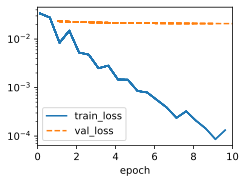

In [10]:
train_scratch(0)

### [**Using Weight Decay**]

Below, we run with substantial weight decay.
Note that the training error increases
but the validation error decreases.
This is precisely the effect
we expect from regularization.


### [**使用权重衰减**]

下面我们以较大的权重衰减运行代码。
注意训练误差增大但验证误差减小。
这正是正则化所期望的效果。

L2 norm of w: 0.0016681021079421043


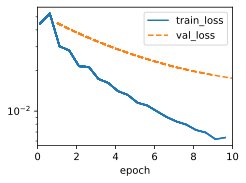

In [11]:
train_scratch(3)

## [**Concise Implementation**]

Because weight decay is ubiquitous
in neural network optimization,
the deep learning framework makes it especially convenient,
integrating weight decay into the optimization algorithm itself
for easy use in combination with any loss function.
Moreover, this integration serves a computational benefit,
allowing implementation tricks to add weight decay to the algorithm,
without any additional computational overhead.
Since the weight decay portion of the update
depends only on the current value of each parameter,
the optimizer must touch each parameter once anyway.


## [**简洁实现**]

由于权重衰减在神经网络优化中很常用，
深度学习框架为了便于使用，
将权重衰减集成到优化算法中，
以便与任何损失函数结合使用。
此外，这种集成还有计算上的好处，
允许在不增加额外计算开销的情况下，
向算法中添加权重衰减这一操作。
由于更新的权重衰减部分仅依赖于每个参数的当前值，
因此优化器必须至少接触每个参数一次。

Below, we specify
the weight decay hyperparameter directly
through `weight_decay` when instantiating our optimizer.
By default, PyTorch decays both
weights and biases simultaneously, but
we can configure the optimizer to handle different parameters
according to different policies.
Here, we only set `weight_decay` for
the weights (the `net.weight` parameters), hence the 
bias (the `net.bias` parameter) will not decay.


在下面的代码中，我们通过实例化优化器时直接设置`weight_decay`来指定权重衰减超参数。
默认情况下，PyTorch会同时衰减权重和偏置，
但我们可以对优化器进行配置，使其能够根据不同策略处理不同参数。
这里我们只为权重参数(`net.weight`)设置了权重衰减，因此偏置参数(`net.bias`)不会发生衰减。

In [13]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

[**The plot looks similar to that when
we implemented weight decay from scratch**].
However, this version runs faster
and is easier to implement,
benefits that will become more
pronounced as you address larger problems
and this work becomes more routine.


[**图像与从零开始实现权重衰减时的结果相似**]。
但这个版本运行速度更快且更易实现，
随着问题规模的扩大和操作流程的常规化，
这些优势会变得更加显著。

L2 norm of w: 0.013817904517054558


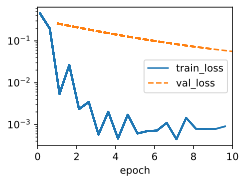

In [14]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

So far, we have touched upon one notion of
what constitutes a simple linear function.
However, even for simple nonlinear functions, the situation can be much more complex. To see this, the concept of [reproducing kernel Hilbert space (RKHS)](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space)
allows one to apply tools introduced
for linear functions in a nonlinear context.
Unfortunately, RKHS-based algorithms
tend to scale poorly to large, high-dimensional data.
In this book we will often adopt the common heuristic
whereby weight decay is applied
to all layers of a deep network.

## Summary

Regularization is a common method for dealing with overfitting. Classical regularization techniques add a penalty term to the loss function (when training) to reduce the complexity of the learned model.
One particular choice for keeping the model simple is using an $\ell_2$ penalty. This leads to weight decay in the update steps of the minibatch stochastic gradient descent algorithm.
In practice, the weight decay functionality is provided in optimizers from deep learning frameworks.
Different sets of parameters can have different update behaviors within the same training loop.



## Exercises

1. Experiment with the value of $\lambda$ in the estimation problem in this section. Plot training and validation accuracy as a function of $\lambda$. What do you observe?
1. Use a validation set to find the optimal value of $\lambda$. Is it really the optimal value? Does this matter?
1. What would the update equations look like if instead of $\|\mathbf{w}\|^2$ we used $\sum_i |w_i|$ as our penalty of choice ($\ell_1$ regularization)?
1. We know that $\|\mathbf{w}\|^2 = \mathbf{w}^\top \mathbf{w}$. Can you find a similar equation for matrices (see the Frobenius norm in :numref:`subsec_lin-algebra-norms`)?
1. Review the relationship between training error and generalization error. In addition to weight decay, increased training, and the use of a model of suitable complexity, what other ways might help us deal with overfitting?
1. In Bayesian statistics we use the product of prior and likelihood to arrive at a posterior via $P(w \mid x) \propto P(x \mid w) P(w)$. How can you identify $P(w)$ with regularization?


到目前为止，我们讨论了如何通过线性函数来定义模型的简单性概念。
然而，即使对于简单的非线性函数，情况也可能变得复杂得多。通过[再生核希尔伯特空间(RKHS)](https://zh.wikipedia.org/wiki/再生核希尔伯特空间)的概念，
我们可以在非线性环境中应用为线性函数开发的工具。
但遗憾的是，基于RKHS的算法在面对大规模高维数据时往往难以扩展。
本书中我们将经常采用一个实用启发式方法：
对深度网络的所有层都应用权重衰减。

## 小结

正则化是处理过拟合的常用方法。经典的正则化技术通过在损失函数(训练时)中添加惩罚项来降低学习模型的复杂度。
保持模型简单的一个特别选择是使用$\ell_2$惩罚，这会导致小批量随机梯度下降更新步骤中的权重衰减。
在实践中，深度学习框架的优化器直接提供了权重衰减功能。
在同一训练循环中，不同的参数组可以有不同的更新行为。

## 练习

1. 在本节的估计问题中调整$\lambda$值。绘制训练精度和验证精度随$\lambda$变化的曲线。观察到了什么？
1. 使用验证集来找到$\lambda$的最优值。这真的是最优值吗？重要吗？
1. 如果改用$\sum_i |w_i|$作为惩罚(即$\ell_1$正则化)，更新方程会是什么样子？
1. 我们知道$\|\mathbf{w}\|^2 = \mathbf{w}^\top \mathbf{w}$。能否找到矩阵的类似等式(参见 :numref:`subsec_lin-algebra-norms`中的Frobenius范数)？
1. 回顾训练误差和泛化误差之间的关系。除了权重衰减、增加训练量和使用适当复杂度的模型外，还有哪些方法可以处理过拟合？
1. 在贝叶斯统计中，我们使用先验和似然的乘积，通过$P(w \mid x) \propto P(x \mid w) P(w)$得到后验。如何将正则化与$P(w)$对应起来？

[Discussions](https://discuss.d2l.ai/t/99)
